In [1]:
import warnings
warnings.filterwarnings('ignore')
from Model_test import *
from Load_and_Clean_data import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
from sklearn.decomposition import PCA

In [2]:
pd.options.display.max_columns = 90

## Load, Clean and Save


In [3]:
df_raw = load_raw_data()

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

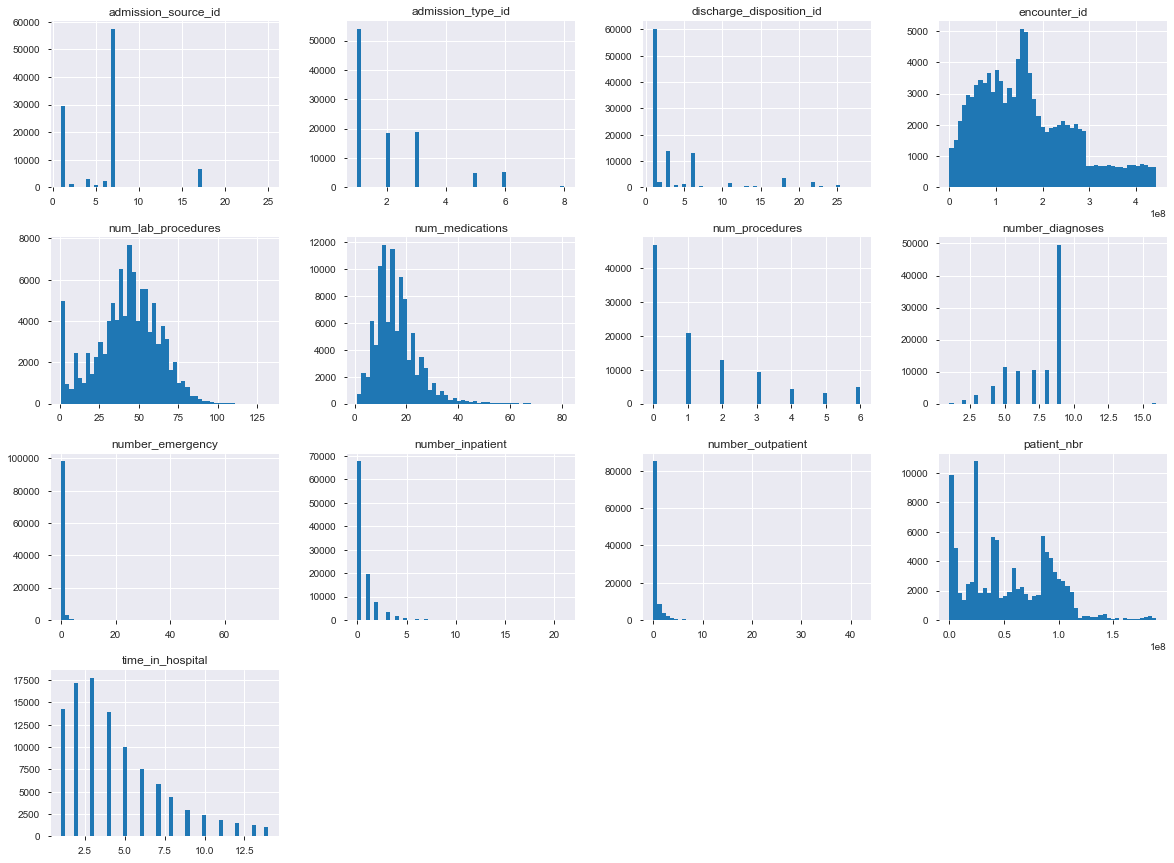

In [5]:
# Visualizing the raw data
df_raw.hist(bins=50, figsize=(20,15));

In [6]:
df = load_raw_data()
df = clean_data(df)

/Users/basselhaidar/Desktop/Mod5 Project /Diabetes_130Hospitals/Load_and_Clean_data.py:24: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.medication_change = np.where(df.change=='No',0,1)


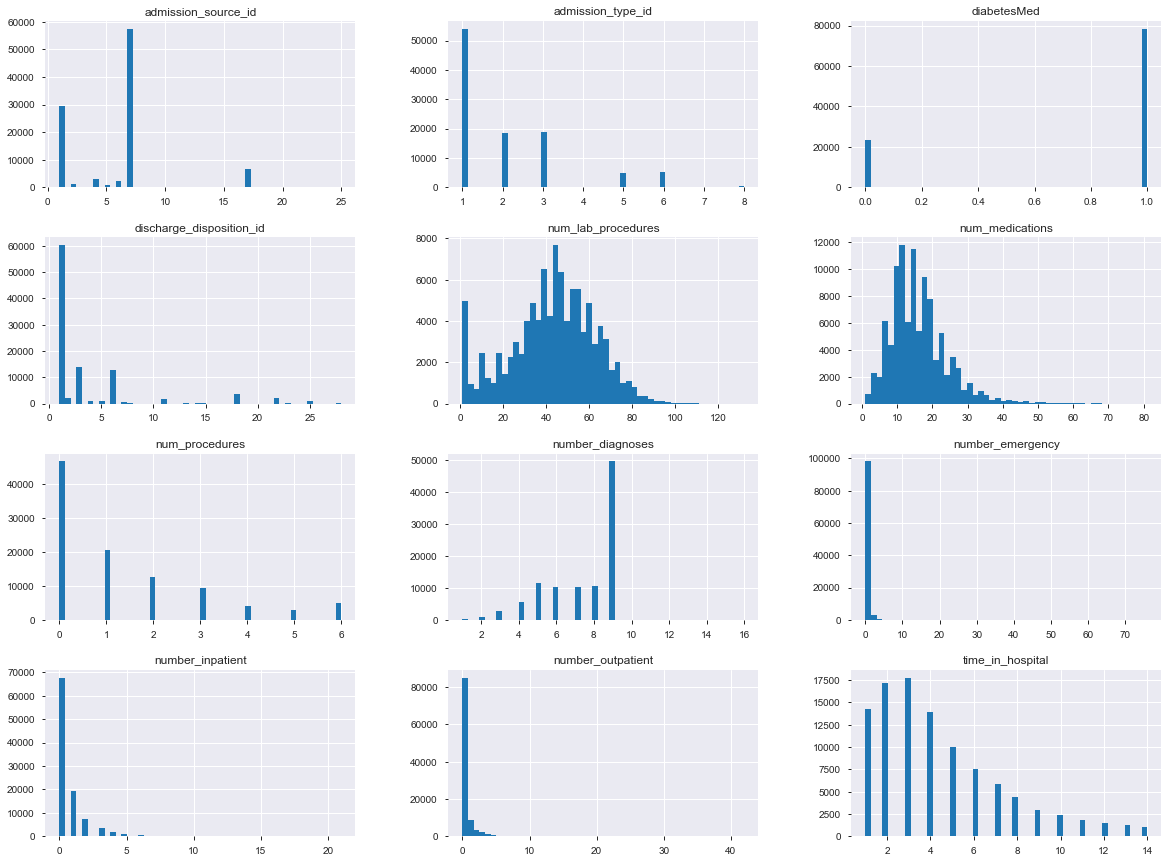

In [7]:
# patient_nbr dropped
df.hist(bins=50, figsize=(20,15));

In [8]:
df.head(5)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,0
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,1,0
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,1,0
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,1,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,1,0


In [9]:
meds_cols =['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

In [10]:
len(meds_cols)

21

## Feature Engineering

In [11]:
# Convert the medicines to numerical values
# Steady or No = 0 , Up = 1, Down = -1
# insulin med is crucial for combatting diabetes and is weighted 2X


for med in meds_cols:
    df[med] = np.where((df[med]=='No' ),0,df[med])
    df[med] = np.where((df[med]=='Steady' ),0,df[med])
    factor = 1
    if(med=='insulin'):
        factor=2
         
    df[med] = np.where((df[med]=='Up' ),1*factor,df[med])
    df[med] = np.where((df[med]=='Down' ),-1*factor,df[med])


###  dosage_up_down : Determine if meds dosage has changed

In [12]:
df['dosage_up_down'] = 0
df['dosage_up'] = 0
df['dosage_down'] = 0
for med in meds_cols:
    df['dosage_up_down'] += df[med]
    df['dosage_up'] += np.where(df[med]>0, df[med], 0)
    df['dosage_down'] += np.where(df[med]<0, df[med], 0)
#     df[df[med]<0]['dosage_down'] += df[med]

In [13]:
# Drop all medicine columns
df.drop(meds_cols, axis=1, inplace=True)

In [14]:
df['dosage_up_down'].value_counts()

 0    74166
-2    11732
 2    10859
 1     2524
-1     1895
 3      381
-3      178
 4       26
-4        5
Name: dosage_up_down, dtype: int64

In [15]:
df['dosage_up'].value_counts()

0    87521
2    11067
1     2757
3      394
4       27
Name: dosage_up, dtype: int64

In [16]:
df['dosage_down'].value_counts()

 0    87659
-2    12085
-1     1818
-3      199
-4        5
Name: dosage_down, dtype: int64

### Categorizing Diagnoses

In [17]:
# The dataset contains three diagnoses for any given patient 
# Each of these diagnoses has over 700 unique ICD codes. We grouped them into 9 disease categories:
# Circulatory(1), Respiratory(2), Digestive(3), Diabetes(4), Injury(5), Musculoskeletal(6)
# Genitourinary(7), Neoplasms(8), and Other(9)

In [18]:

def get_diagnosis(col_name):
    print('converting diagnosis for', col_name)
    new_name = 'cat1_'+col_name
    df[new_name] = df[col_name]
    
    df[new_name] = np.where( ((df[col_name].str.contains('V', na=False)) | 
                            (df[col_name].str.contains('E', na=False)) ), 9, df[new_name])
    df[new_name] = np.where(df[new_name]=='?', -1, df[new_name] )
    
    df[new_name] = df[new_name].astype(float)
    
    df[new_name] = np.where( (((df[new_name]>=390) & (df[new_name]<460)) | (np.floor(df[new_name])==785) ),1, df[new_name] )
    
    df[new_name] = np.where( (((df[new_name]>=460) & (df[new_name]<520)) | (np.floor(df[new_name])==786) ),2, df[new_name] )
    
    df[new_name] = np.where( (((df[new_name]>=520) & (df[new_name]<580)) | (np.floor(df[new_name])==787) ),3, df[new_name] )
    
    df[new_name] = np.where( (np.floor(df[new_name])==250  ) ,4,df[new_name])
    
    df[new_name] = np.where( ((df[new_name] >=800) & (df[new_name]<1000)),5,df[new_name])
    
    df[new_name] = np.where( ((df[new_name] >=710) & (df[new_name]<740)),6,df[new_name])
    
    df[new_name] = np.where( (((df[new_name]>=580) & (df[new_name]<630)) | (np.floor(df[new_name])==788) ),7, df[new_name] )
    
    df[new_name] = np.where( ((df[new_name] >=140) & (df[new_name]<240)),8,df[new_name])
    
    df[new_name] = np.where( df[new_name] >9, 9, df[new_name])
    


In [19]:
get_diagnosis('diag_1')
get_diagnosis('diag_2')
get_diagnosis('diag_3')

converting diagnosis for diag_1
converting diagnosis for diag_2
converting diagnosis for diag_3


In [20]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,diabetesMed,readmitted,dosage_up_down,dosage_up,dosage_down,cat1_diag_1,cat1_diag_2,cat1_diag_3
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,0,0,0,0,0,4.0,-1.0,-1.0
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,1,0,2,2,0,9.0,4.0,9.0
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,1,0,0,0,0,9.0,4.0,9.0
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,1,0,2,2,0,8.0,4.0,1.0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,1,0,0,0,0,8.0,8.0,4.0


In [21]:
# Drop the original 3 diagnoses columns
df.drop(columns = ['diag_1', 'diag_2', 'diag_3'], inplace=True)

In [22]:
# df.drop(columns=['level1_diag1'], inplace=True)
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,diabetesMed,readmitted,dosage_up_down,dosage_up,dosage_down,cat1_diag_1,cat1_diag_2,cat1_diag_3
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,1,None,None,0,0,0,0,0,4.0,-1.0,-1.0
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,9,None,None,1,0,2,2,0,9.0,4.0,9.0
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,6,None,None,1,0,0,0,0,9.0,4.0,9.0
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,7,None,None,1,0,2,2,0,8.0,4.0,1.0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,5,None,None,1,0,0,0,0,8.0,8.0,4.0


In [23]:
df.admission_source_id.nunique()

17

### total_visits: collapsing 3 columns into 1
#### number_inpatient + number_outpatient + number_emergency

In [24]:
# add all the previous visits a hospital
df['total_visits'] = df.number_inpatient + df.number_outpatient + df.number_emergency
# df.drop(columns=['number_inpatient', 'number_outpatient','number_emergency'],inplace=True)
df.drop(columns=['number_inpatient', 'number_outpatient'],inplace=True)

In [25]:
df.shape

(101766, 23)

### Creating an LAE Index 
#### L: number of days spent in the hospital , A: the acuity (emergency or not) of admission, E: number of emergecny visits in the past year

In [26]:
# Emergency, Urgent and Trauma Center admissions types are converted to 1, the rest to 0

df['admission'] = 0
df['admission'] = np.where( df.admission_type_id <3 , 1, 0 )
df['admission'] = np.where( df.admission_type_id == 7, 1, df.admission )
df.drop(columns=['admission_type_id'], inplace=True)

In [27]:
# add number of procedures and lab procedure into total_procedures

df.total_procedures = df.num_lab_procedures + df.num_procedures
df.drop(columns=['num_lab_procedures', 'num_procedures'], inplace=True)

/anaconda3/envs/flatiron/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
# Creating an index based on the LACE index
# L : day(s) in the hospital
# A : acuity of admission,  3 for emergency, 0 otherwise
# E : number of emergency visits 4 or smaller


In [29]:
df['LAE_index'] = df['time_in_hospital']
# get the L value

df['LAE_index'] = np.where(((df['time_in_hospital']>4) & (df['time_in_hospital']<7)), 4, df['LAE_index'])
df['LAE_index'] = np.where(((df['time_in_hospital']>6) & (df['time_in_hospital']<14)), 5, df['LAE_index'])
df['LAE_index'] = np.where( (df['time_in_hospital']>13), 7, df['LAE_index'])



In [30]:

df['LAE_index'] +=  df['admission']*3


In [31]:
df['LAE_index'] = np.where( df['number_emergency']>=4, 
                           df['LAE_index'] +4, df['LAE_index']+df['number_emergency'])

In [32]:
# df.drop('LAE_index2', axis=1, inplace=True)

In [33]:
df[df.number_emergency>1][['time_in_hospital','admission' ,'number_emergency','LAE_index']].head(25)

,time_in_hospital,admission,number_emergency,LAE_index
883,3,1,2,8
1716,4,1,4,11
1851,1,1,2,6
2320,2,0,2,4
2934,1,1,2,6
2958,1,1,4,8
3139,4,1,2,9
3268,1,0,2,3
3307,3,1,2,8
3394,2,1,2,7


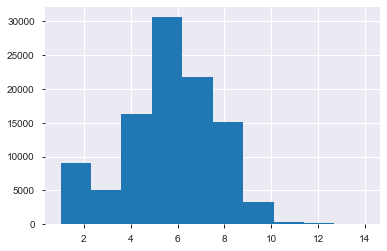

In [34]:
df.LAE_index.hist()

In [35]:
df.shape

(101766, 22)

In [36]:
df['dosage_up_down'] = df['dosage_up_down'].astype(int);
# df['dosage_up'] = df['dosage_up'].astype(int);
# df['dosage_down'] = df['dosage_down'].astype(int);
df['readmitted'] = df['readmitted'].astype(int);

In [37]:
df.drop(columns=['dosage_up','dosage_down'], inplace=True)

In [38]:
def sort_asc_corr(df, value):
    ''' Return correlation in descending order
        based on the specified value parameter
        in our case, we will be using the
        dependent variable price '''

    corr_df = df.corr()[[value]]
    return corr_df.sort_values(by = value, ascending=False)

In [39]:
sort_asc_corr(df, 'readmitted')

,readmitted
readmitted,1.000000
total_visits,0.126114
LAE_index,0.063863
number_emergency,0.060747
discharge_disposition_id,0.050560
number_diagnoses,0.049524
time_in_hospital,0.044199
num_medications,0.038432
diabetesMed,0.027125
admission,0.013586


In [12]:
df.plot(kind="scatter", x="readmitted", y="total_visits")

NameError: name 'df' is not defined

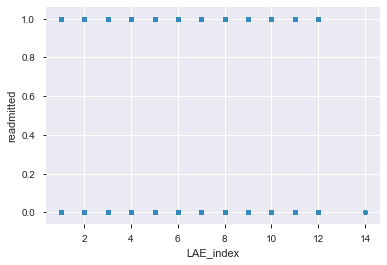

In [41]:
df.plot(kind="scatter",y="readmitted", x="LAE_index")

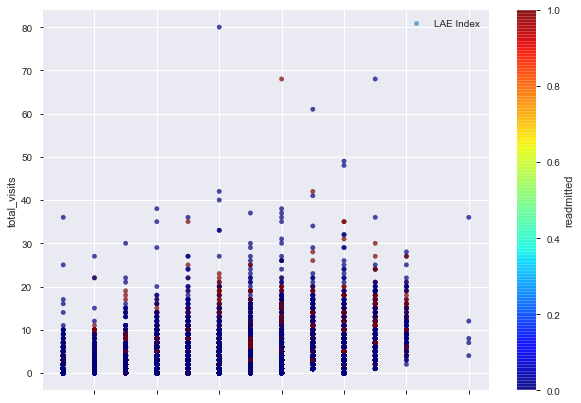

In [42]:
df.plot(kind="scatter", x="LAE_index", y="total_visits", alpha=0.7,
    label="LAE Index", figsize=(10,7),
    c="readmitted", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend();

In [43]:
sort_asc_corr(df, 'LAE_index')

,LAE_index
LAE_index,1.000000
admission,0.692294
time_in_hospital,0.607444
number_diagnoses,0.249252
number_emergency,0.236851
num_medications,0.211906
total_visits,0.200454
admission_source_id,0.100294
readmitted,0.063863
diabetesMed,0.058372


In [44]:
# create column for patients who left against medical advice (LAMA)
df['LAMA'] = 0
df['LAMA'] = np.where( df['discharge_disposition_id']==7, 1, 0)

In [45]:
df.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,num_medications,number_emergency,number_diagnoses,max_glu_serum,A1Cresult,diabetesMed,readmitted,dosage_up_down,cat1_diag_1,cat1_diag_2,cat1_diag_3,total_visits,admission,LAE_index,LAMA
0,Caucasian,Female,[0-10),25,1,1,1,0,1,None,None,0,0,0,4.0,-1.0,-1.0,0,0,1,0
1,Caucasian,Female,[10-20),1,7,3,18,0,9,None,None,1,0,2,9.0,4.0,9.0,0,1,6,0
2,AfricanAmerican,Female,[20-30),1,7,2,13,0,6,None,None,1,0,0,9.0,4.0,9.0,3,1,5,0
3,Caucasian,Male,[30-40),1,7,2,16,0,7,None,None,1,0,2,8.0,4.0,1.0,0,1,5,0
4,Caucasian,Male,[40-50),1,7,1,8,0,5,None,None,1,0,0,8.0,8.0,4.0,0,1,4,0


In [46]:
# remove discharge_disposition_id and admission_source_id as they are categorical
# df.drop(columns=['discharge_disposition_id', 'admission_source_id'], inplace=True)
df.drop(columns=[ 'admission_source_id'], inplace=True)

In [47]:
df.max_glu_serum.unique()

array(['None', '>300', 'Norm', '>200'], dtype=object)

In [48]:
df['max_glu_serum'] = np.where(df['max_glu_serum']=='>300', 1,df['max_glu_serum'])
df['max_glu_serum'] = np.where(df['max_glu_serum']=='>200', 1,df['max_glu_serum'])
df['max_glu_serum'] = np.where(df['max_glu_serum']=='Norm', 0,df['max_glu_serum'])
df['max_glu_serum'] = np.where(df['max_glu_serum']=='None', 0,df['max_glu_serum'])
df['max_glu_serum'] = df['max_glu_serum'].astype(int)

In [49]:
df.max_glu_serum.unique()

array([0, 1])

In [50]:
df.A1Cresult.unique()

array(['None', '>7', '>8', 'Norm'], dtype=object)

In [51]:
df['A1Cresult'] = np.where(df['A1Cresult']=='>8', 1,df['A1Cresult'])
df['A1Cresult'] = np.where(df['A1Cresult']=='>7', 1,df['A1Cresult'])
df['A1Cresult'] = np.where(df['A1Cresult']=='Norm', 0,df['A1Cresult'])
df['A1Cresult'] = np.where(df['A1Cresult']=='None', 0,df['A1Cresult'])
df['A1Cresult'] = df['A1Cresult'].astype(int)

In [52]:
df.A1Cresult.unique()

array([0, 1])

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 20 columns):
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
discharge_disposition_id    101766 non-null int64
time_in_hospital            101766 non-null int64
num_medications             101766 non-null int64
number_emergency            101766 non-null int64
number_diagnoses            101766 non-null int64
max_glu_serum               101766 non-null int64
A1Cresult                   101766 non-null int64
diabetesMed                 101766 non-null int64
readmitted                  101766 non-null int64
dosage_up_down              101766 non-null int64
cat1_diag_1                 101766 non-null float64
cat1_diag_2                 101766 non-null float64
cat1_diag_3                 101766 non-null float64
total_visits                101766 non-null int64
admission                   10

In [54]:
dummy_df = pd.get_dummies(df)

In [55]:
dummy_df.head()

,discharge_disposition_id,time_in_hospital,num_medications,number_emergency,number_diagnoses,max_glu_serum,A1Cresult,diabetesMed,readmitted,dosage_up_down,cat1_diag_1,cat1_diag_2,cat1_diag_3,total_visits,admission,LAE_index,LAMA,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100)
0,25,1,1,0,1,0,0,0,0,0,4.0,-1.0,-1.0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,1,3,18,0,9,0,0,1,0,2,9.0,4.0,9.0,0,1,6,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,1,2,13,0,6,0,0,1,0,0,9.0,4.0,9.0,3,1,5,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,1,2,16,0,7,0,0,1,0,2,8.0,4.0,1.0,0,1,5,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,1,1,8,0,5,0,0,1,0,0,8.0,8.0,4.0,0,1,4,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [56]:
# Bin age into 3 categories
dummy_df['age_60_100'] = dummy_df['age_[60-70)']+dummy_df['age_[70-80)']+dummy_df['age_[80-90)']+dummy_df['age_[90-100)']
dummy_df['age_30_60'] = dummy_df['age_[30-40)']+dummy_df['age_[40-50)']+dummy_df['age_[50-60)']
dummy_df['age_0_30'] = dummy_df['age_[0-10)']+dummy_df['age_[10-20)']+dummy_df['age_[20-30)']

In [57]:
dummy_df.columns

Index(['discharge_disposition_id', 'time_in_hospital', 'num_medications',
       'number_emergency', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'diabetesMed', 'readmitted', 'dosage_up_down', 'cat1_diag_1',
       'cat1_diag_2', 'cat1_diag_3', 'total_visits', 'admission', 'LAE_index',
       'LAMA', 'race_AfricanAmerican', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'gender_Female', 'gender_Male',
       'gender_Unknown/Invalid', 'age_[0-10)', 'age_[10-20)', 'age_[20-30)',
       'age_[30-40)', 'age_[40-50)', 'age_[50-60)', 'age_[60-70)',
       'age_[70-80)', 'age_[80-90)', 'age_[90-100)', 'age_60_100', 'age_30_60',
       'age_0_30'],
      dtype='object')

In [58]:
to_drop = ['age_[0-10)', 'age_[10-20)', 'age_[20-30)', 'age_[30-40)',
       'age_[40-50)', 'age_[50-60)', 'age_[60-70)', 'age_[70-80)',
       'age_[80-90)', 'age_[90-100)', 'gender_Male', 'gender_Unknown/Invalid','race_Other']

In [59]:
# Drop old age columns, leave female column (1 = female, 0 = male), and drop race_Other (can still be identified)
dummy_df.drop(columns=to_drop,inplace=True)

In [60]:
cleaned_df = dummy_df.copy()

In [61]:
cleaned_df.head()

,discharge_disposition_id,time_in_hospital,num_medications,number_emergency,number_diagnoses,max_glu_serum,A1Cresult,diabetesMed,readmitted,dosage_up_down,cat1_diag_1,cat1_diag_2,cat1_diag_3,total_visits,admission,LAE_index,LAMA,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,gender_Female,age_60_100,age_30_60,age_0_30
0,25,1,1,0,1,0,0,0,0,0,4.0,-1.0,-1.0,0,0,1,0,0,0,1,0,1,0,0,1
1,1,3,18,0,9,0,0,1,0,2,9.0,4.0,9.0,0,1,6,0,0,0,1,0,1,0,0,1
2,1,2,13,0,6,0,0,1,0,0,9.0,4.0,9.0,3,1,5,0,1,0,0,0,1,0,0,1
3,1,2,16,0,7,0,0,1,0,2,8.0,4.0,1.0,0,1,5,0,0,0,1,0,0,0,1,0
4,1,1,8,0,5,0,0,1,0,0,8.0,8.0,4.0,0,1,4,0,0,0,1,0,0,0,1,0


In [62]:
cleaned_df.shape

(101766, 25)

In [63]:
cleaned_df.cat1_diag_1.unique()

array([ 4.,  9.,  8.,  1.,  2.,  5.,  6.,  3.,  7., -1.])

In [64]:
cleaned_df['diagnosis'] = cleaned_df['cat1_diag_1']

In [65]:
# Collapse all diagnosis into one column
cleaned_df['diagnosis'] = np.where( ((cleaned_df['cat1_diag_2']==cleaned_df['cat1_diag_3']) & (cleaned_df['cat1_diag_2']>0)),
                                   cleaned_df['cat1_diag_2'], cleaned_df['cat1_diag_1'] )
cleaned_df['diagnosis'] = np.where( cleaned_df['diagnosis']==-1, cleaned_df['cat1_diag_2'], cleaned_df['diagnosis'])

In [66]:
cleaned_df['diagnosis'] = cleaned_df['diagnosis'].astype(int)

In [67]:
cleaned_df['diagnosis'] = cleaned_df['diagnosis'].astype(str)

In [68]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 26 columns):
discharge_disposition_id    101766 non-null int64
time_in_hospital            101766 non-null int64
num_medications             101766 non-null int64
number_emergency            101766 non-null int64
number_diagnoses            101766 non-null int64
max_glu_serum               101766 non-null int64
A1Cresult                   101766 non-null int64
diabetesMed                 101766 non-null int64
readmitted                  101766 non-null int64
dosage_up_down              101766 non-null int64
cat1_diag_1                 101766 non-null float64
cat1_diag_2                 101766 non-null float64
cat1_diag_3                 101766 non-null float64
total_visits                101766 non-null int64
admission                   101766 non-null int64
LAE_index                   101766 non-null int64
LAMA                        101766 non-null int64
race_AfricanAmerican        10176

In [69]:
diagnosis_df = pd.get_dummies(cleaned_df)

In [70]:
diagnosis_df.drop(columns=['cat1_diag_1', 'cat1_diag_2','cat1_diag_3'], inplace=True)
diagnosis_df.head()

,discharge_disposition_id,time_in_hospital,num_medications,number_emergency,number_diagnoses,max_glu_serum,A1Cresult,diabetesMed,readmitted,dosage_up_down,total_visits,admission,LAE_index,LAMA,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,gender_Female,age_60_100,age_30_60,age_0_30,diagnosis_-1,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_4,diagnosis_5,diagnosis_6,diagnosis_7,diagnosis_8,diagnosis_9
0,25,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
1,1,3,18,0,9,0,0,1,0,2,0,1,6,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
2,1,2,13,0,6,0,0,1,0,0,3,1,5,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
3,1,2,16,0,7,0,0,1,0,2,0,1,5,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,1,1,8,0,5,0,0,1,0,0,0,1,4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [71]:
diagnosis_df.shape

(101766, 32)

In [72]:
diagnosis_df[diagnosis_df['diagnosis_-1']==1]

,discharge_disposition_id,time_in_hospital,num_medications,number_emergency,number_diagnoses,max_glu_serum,A1Cresult,diabetesMed,readmitted,dosage_up_down,total_visits,admission,LAE_index,LAMA,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,gender_Female,age_60_100,age_30_60,age_0_30,diagnosis_-1,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_4,diagnosis_5,diagnosis_6,diagnosis_7,diagnosis_8,diagnosis_9
87181,13,7,14,0,5,0,0,0,0,0,1,1,8,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


## Remove some patients

In [73]:
# drop patients with no diagnosis, only 1 row
print(len(diagnosis_df))
diagnosis_df = diagnosis_df[diagnosis_df['diagnosis_-1']==0]
print(len(diagnosis_df))

101766
101765


In [74]:
diagnosis_df.drop(columns=['diagnosis_-1'], inplace=True)

In [75]:
diagnosis_df.shape

(101765, 31)

In [76]:
print('number of patients', len(diagnosis_df))
# remove patients that died (expired), 
len(diagnosis_df[diagnosis_df.discharge_disposition_id==11])
diagnosis_df = diagnosis_df[diagnosis_df.discharge_disposition_id!=11]
# remove patients that have moved to hospice (home or medical facility)
diagnosis_df = diagnosis_df[diagnosis_df.discharge_disposition_id!=13]
diagnosis_df = diagnosis_df[diagnosis_df.discharge_disposition_id!=14]

# remove patients expired at home. medical facility or unknown
diagnosis_df = diagnosis_df[diagnosis_df.discharge_disposition_id!=19]
diagnosis_df = diagnosis_df[diagnosis_df.discharge_disposition_id!=20]
diagnosis_df = diagnosis_df[diagnosis_df.discharge_disposition_id!=21]
print('number of patients', len(diagnosis_df))

number of patients 101765
number of patients 99343


In [77]:
# Save cleaned and feature engineered dataset
diagnosis_df.to_csv('dataset_diabetes/reduced_and_cleaned.csv')

In [4]:
# Load dataset
diagnosis_df = pd.read_csv('dataset_diabetes/reduced_and_cleaned.csv')

# Scale and split data

In [5]:
X = diagnosis_df.drop('readmitted',axis=1)
y = diagnosis_df['readmitted']

In [6]:
X_train, X_test, y_train, y_test = scale_train_test_split(X,y)

In [7]:
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state=109)
X_train, y_train = sm.fit_sample(X_train, y_train)



In [8]:
models, model_names = train_model(X_train, y_train)

Running AdaBoost
Running GradientBoost
Running Logistic Regression
Running DecisionTree_gini
Running DecisionTree_entropy


In [9]:
y_train_predicts = predict_all(X_train, y_train, models)
y_test_predicts = predict_all(X_test, y_test, models)

Predictions for AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Predictions for GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Predictions for LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=No

In [10]:
print('--- Train data ---')
for i,y_train_pred in enumerate(y_train_predicts):
    display_acc_and_f1_score(y_train, y_train_pred, model_names[i])
print('\n\n--- Test data ---')
for i,y_test_pred in enumerate(y_test_predicts):
    display_acc_and_f1_score(y_test, y_test_pred, model_names[i])

--- Train data ---
Model: AdaBoost
Accuracy: 0.8897034321892703
F1-Score: 0.8897034321892703
Model: GradientBoost
Accuracy: 0.8918087910090576
F1-Score: 0.8918087910090576
Model: Logistic Regression
Accuracy: 0.8681575838356911
F1-Score: 0.8681575838356911
Model: DecisionTree_gini
Accuracy: 0.8445593892944776
F1-Score: 0.8445593892944776
Model: DecisionTree_entropy
Accuracy: 0.8404698433855382
F1-Score: 0.8404698433855382


--- Test data ---
Model: AdaBoost
Accuracy: 0.8687791914962152
F1-Score: 0.8687791914962153
Model: GradientBoost
Accuracy: 0.8820260911579965
F1-Score: 0.8820260911579965
Model: Logistic Regression
Accuracy: 0.8531567080045096
F1-Score: 0.8531567080045095
Model: DecisionTree_gini
Accuracy: 0.7943710742470608
F1-Score: 0.7943710742470608
Model: DecisionTree_entropy
Accuracy: 0.8030681269125463
F1-Score: 0.8030681269125464


In [11]:
for i, y_test_pred in enumerate(y_test_predicts):
    print(confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))

[[21441   566]
 [ 2693   136]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     22007
           1       0.19      0.05      0.08      2829

    accuracy                           0.87     24836
   macro avg       0.54      0.51      0.50     24836
weighted avg       0.81      0.87      0.83     24836

[[21886   121]
 [ 2809    20]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     22007
           1       0.14      0.01      0.01      2829

    accuracy                           0.88     24836
   macro avg       0.51      0.50      0.48     24836
weighted avg       0.80      0.88      0.83     24836

[[20920  1087]
 [ 2560   269]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     22007
           1       0.20      0.10      0.13      2829

    accuracy                           0.85     24836
   macro avg       0.54      0.52  

In [ ]:
# Load and clean the data
# df = load_raw_data()
# df = clean_data(df)

# get features and target
# X,y = df_featues_target(df)

# save to a file
# save_X_y(X,y)


In [ ]:
#load from file
X,y = load_X_y()

In [ ]:
# pandas_profiling.ProfileReport(df)

## Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = scale_train_test_split(X,y)

## Base Model

In [ ]:
models, model_names = train_model(X_train, y_train)

In [ ]:
y_train_predicts = predict_all(X_train, y_train, models)

In [ ]:
y_test_predicts = predict_all(X_test, y_test, models)

In [ ]:

print('--- Train data ---')
for i,y_train_pred in enumerate(y_train_predicts):
    display_acc_and_f1_score(y_train, y_train_pred, model_names[i])
print('\n\n--- Test data ---')
for i,y_test_pred in enumerate(y_test_predicts):
    display_acc_and_f1_score(y_test, y_test_pred, model_names[i])

In [ ]:
# Decision Tree overfitting because we did not limit number of splits yet

## Iteration #2

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state=109)
X_new_train, y_new_train = sm.fit_sample(X_train, y_train)



In [ ]:
print(np.unique(y_new_train, return_counts=True))
np.unique(y, return_counts=True)

In [ ]:
type(X_new_train), type(y_new_train)

In [ ]:
type(X_test), type(y_test)

In [ ]:
models, model_names = train_model(X_new_train, y_new_train)

In [ ]:
y_new_train_predicts = predict_all(X_new_train, y_new_train, models)

In [ ]:
y_new_test_predicts = predict_all(np.array(X_test), np.array(y_test), models)

In [ ]:

print('--- Train data ---')
for i, y_new_train_pred in enumerate(y_new_train_predicts):
    display_acc_and_f1_score(y_new_train, y_new_train_pred, model_names[i])
print('\n\n--- Test data ---')
for i,y_new_test_pred in enumerate(y_new_test_predicts):
    display_acc_and_f1_score(y_test, y_new_test_pred, model_names[i])

## Iteration #3

In [ ]:
len(X.columns)

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

pca_1 = PCA(n_components=20)
pca_2 = PCA(n_components=40)
pca_3 = PCA(n_components=60)

principalComponents = pca_1.fit_transform(X)
principalComponents = pca_2.fit_transform(X)
principalComponents = pca_3.fit_transform(X)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))





# print(pca_1.explained_variance_ratio_)
# print(pca_2.explained_variance_ratio_)
# print(pca_3.explained_variance_ratio_)
# print(np.sum(pca_2.explained_variance_ratio_))
# print(np.sum(pca_3.explained_variance_ratio_))

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
print(np.sum(pca.explained_variance_ratio_))

In [ ]:
pca_df = pd.DataFrame(principalComponents, columns= ['PCA1','PCA2'])

In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = scale_train_test_split(pca_df,y)

In [ ]:
models, model_names = train_model(X_train_pca, y_train_pca)

In [ ]:
y_train_predicts = predict_all(X_train_pca, y_train_pca, models)
y_test_predicts = predict_all(X_test_pca, y_test_pca, models)

In [ ]:
print('--- Train data ---')
for i, y_new_train_pred in enumerate(y_train_predicts):
    display_acc_and_f1_score(y_train, y_new_train_pred, model_names[i])
print('\n\n--- Test data ---')
for i,y_new_test_pred in enumerate(y_test_predicts):
    display_acc_and_f1_score(y_test, y_new_test_pred, model_names[i])

## Iteration #4 setup a pipeline

In [ ]:
# grid search over Desicion Trees
grid = find_best_tree_clf(X_train,  y_train)

In [ ]:
y_pred = grid.predict(X_train)
display_acc_and_f1_score(y_train, y_pred, 'tree CV')

y_pred = grid.predict(X_test)
display_acc_and_f1_score(y_test, y_pred, 'tree CV')


In [ ]:
grid.best_estimator_
grid.best_score_

In [ ]:
grid.cv_results_['mean_test_score']

In [ ]:
## logistic grid search CV
lr_grid = find_best_logistic(X_train, y_train)

In [ ]:
lr_grid.cv_results_

y_pred = lr_grid.predict(X_train)
display_acc_and_f1_score(y_train, y_pred, 'tree CV')

y_pred = lr_grid.predict(X_test)
display_acc_and_f1_score(y_test, y_pred, 'tree CV')

In [ ]:
gbt_clf = GradientBoostingClassifier()
gbt_clf.fit(X_train, y_train)
models.append(gbt_clf)

In [ ]:
logistic = LogisticRegression()

pipe = Pipeline([('logistic', logistic)])
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']

parameters = dict(logistic__C=C,
                  logistic__penalty=penalty)

clf = GridSearchCV(pipe, parameters)


In [ ]:
clf.fit(X_train, y_train)

In [ ]:
print('Best Penalty:', clf.best_estimator_.get_params()['logistic__penalty'])
print('Best C:', clf.best_estimator_.get_params()['logistic__C'])

## Columns to inspect

    - Admission_type_id
  a  - discharge_disposition_id
    - admission_source_id
    - number_of_lab_procedures
    

In [13]:
from sklearn.model_selection import cross_val_score